### imports and inits

In [1]:
%cd ..
from src import utils
import hydra
from omegaconf import DictConfig
import numpy as np
import os
import torch
from src.utils.metrics import pad_label_label
# from src.utils import general_helpers
from typing import List
import seaborn as sns

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.loggers.logger import Logger

import src.utils.general as utils
# Load config
import hydra
import matplotlib.pyplot as plt

/dlabdata1/masani/blocks


/dlabdata1/masani/miniconda3/envs/blocks/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title functions to load, run and find the errors of models.

log = utils.get_pylogger(__name__)

configs_path = "../configs"
config_name = "inference_root.yaml"

def run_inference(config: DictConfig):
    # assert config.output_dir is not None, "Path to the directory in which the predictions will be written must be given"
    # config.output_dir = general_helpers.get_absolute_path(config.output_dir)
    # log.info(f"Output directory: {config.output_dir}")

    # Set seed for random number generators in PyTorch, Numpy and Python (random)
    if config.get("seed"):
        pl.seed_everything(config.seed, workers=True)

    # print current working directory
    log.info(f"Current working directory: {os.getcwd()}")

    # Convert relative ckpt path to absolute path if necessary
    ckpt_path = config.trainer.get("resume_from_checkpoint")
    if ckpt_path and not os.path.isabs(ckpt_path):
        config.trainer.resume_from_checkpoint = os.path.join(hydra.utils.get_original_cwd(), ckpt_path)

    log.info(f"Instantiating data module <{config.datamodule._target_}>")
    datamodule: LightningDataModule = hydra.utils.instantiate(config.datamodule, _recursive_=False)

    # print(datamodule.data_val[0])

    log.info(f"Instantiating model <{config.model._target_}>")
    model: LightningModule = hydra.utils.instantiate(config.model, datamodule=datamodule, _recursive_=False)

    model.eval()
    
    # If defined, use the model's collate function (otherwise proceed with the PyTorch's default collate_fn)
    if getattr(model, "collator", None):
        datamodule.set_collate_fn(model.collator.collate_fn)
    
    # Init LIT loggers
    # logger: List[LightningLoggerBase] = []
    # logger: List[Logger] = []
    # if "logger" in config:
    #     for _, lg_conf in config.logger.items():
    #         if "_target_" in lg_conf:
    #             log.info(f"Instantiating logger <{lg_conf._target_}>")
    #             logger.append(hydra.utils.instantiate(lg_conf))
    #             if lg_conf["_target_"] == 'pytorch_lightning.loggers.wandb.WandbLogger' and config.get("track_gradients",False):
    #                 logger[-1].watch(model)
    
    # callbacks = []

    # Init lightning trainer
    # log.info(f"Instantiating trainer <{config.trainer._target_}>")
    # trainer: Trainer = hydra.utils.instantiate(config.trainer, logger=logger, _convert_="partial")

    # # Send some parameters from configs to all lightning loggers
    # log.info("Logging hyperparameters!")
    # utils.log_hyperparameters(
    #     config= config,
    #     model=model,
    #     datamodule=datamodule,
    #     trainer=trainer,
    #     callbacks=callbacks,
    #     logger=logger,
    # )

    return model, datamodule

# constructing forward pass
def forward(model, datamodule, id, dataset='val'):
    model_x_to_z = model.model_x_to_z
    model_z_to_x = model.model_z_to_x
    disc_x = model.disc_x
    disc_z = model.disc_z

    if dataset=='val':
        batch = datamodule.data_val[id]
    elif dataset=='train':
        batch = datamodule.data_train[id]
    elif dataset=='test':
        batch = datamodule.data_test[id]
    
    collated_batch = model.collator.collate_fn([batch])
    collated_batch_device = datamodule.transfer_batch_to_device(batch=collated_batch, device=model.device, dataloader_idx=0)

    forward_from_batch(model, batch, collated_batch_device)


def correct_val_predictions(model, datamodule):
    correct_z_ids = []
    correct_x_ids = []

    val_dataloader = datamodule.val_dataloader()
    for batch in val_dataloader:
        
        collated_batch = batch
        collated_batch_device = datamodule.transfer_batch_to_device(batch=collated_batch, device=model.device, dataloader_idx=0)

        loss, losses, outputs = model.forward(batch=collated_batch_device, stage='val')

        x_ids = collated_batch_device['x_ids']
        x_hat_ids = outputs['zxz']['x_hat_ids']
        x_ids, x_hat_ids = pad_label_label(collated_batch_device['x_ids'][:, 1:], x_hat_ids, pad_token_id=model.pad_token_id)
        x_pad_mask = torch.logical_not(torch.eq(x_ids, model.pad_token_id))
        x_hat_ids = x_hat_ids * x_pad_mask

        z_ids = collated_batch_device['z_ids']
        z_hat_ids = outputs['xzx']['z_hat_ids']
        z_ids, z_hat_ids = pad_label_label(z_ids[:, 1:], z_hat_ids, pad_token_id=model.pad_token_id)
        z_pad_mask = torch.logical_not(torch.eq(z_ids, model.pad_token_id))
        z_hat_ids = z_hat_ids * z_pad_mask

        z_pred_flag = torch.eq(z_hat_ids, z_ids).all(axis=-1)
        z_pred_flag_ids = list(torch.where(z_pred_flag)[0].cpu().numpy())

        x_pred_flag = torch.eq(x_hat_ids, x_ids).all(axis=-1)
        x_pred_flag_ids = list(torch.where(x_pred_flag)[0].cpu().numpy())

        correct_z_ids.extend(batch['id'][z_pred_flag_ids])
        correct_x_ids.extend(batch['id'][x_pred_flag_ids])

    return correct_z_ids, correct_x_ids

def forward_from_batch(model, batch, collated_batch_device):
    
    model_x_to_z = model.model_x_to_z
    model_z_to_x = model.model_z_to_x
    disc_x = model.disc_x
    disc_z = model.disc_z

    loss, losses, outputs = model.forward(batch=collated_batch_device, stage='val')
    x_hat_ids = outputs['zxz']['x_hat_ids']
    z_hat_ids = outputs['xzx']['z_hat_ids']
    x_ids, x_hat_ids = pad_label_label(collated_batch_device['x_ids'][:, 1:], x_hat_ids, pad_token_id=model.pad_token_id)
    z_ids, z_hat_ids = pad_label_label(collated_batch_device['z_ids'][:, 1:], z_hat_ids, pad_token_id=model.pad_token_id)
    x_hat_scores = torch.round(outputs['zxz']['x_hat_scores'][0],  decimals=3)
    z_hat_scores = torch.round(outputs['xzx']['z_hat_scores'][0],  decimals=3)
    

    print('x= '.rjust(20), batch['x'])
    print('x_ids= '.rjust(20), x_ids.cpu().numpy())
    print('x_hat_text= '.rjust(20), model.collator.tokenizer_x.decode(x_hat_ids.cpu().numpy()[0]))
    print('x_hat_ids= '.rjust(20), x_hat_ids.cpu().numpy())
    print('equalities= '.rjust(20), (x_hat_ids == x_ids).cpu().numpy())
    print('x_hat_scores= '.rjust(20), x_hat_scores.max(dim=-1).values.cpu().detach().numpy())
    print('_____________________________________________________________________________________')
    print('z= '.rjust(20), batch['z'])
    print('z_ids= '.rjust(20), z_ids.cpu().numpy())
    print('z_hat_text= '.rjust(20), model.collator.tokenizer_z.decode(z_hat_ids.cpu().numpy()[0]))
    print('z_hat_ids= '.rjust(20), z_hat_ids.cpu().numpy())
    print('equalities= '.rjust(20), (z_hat_ids == z_ids).cpu().numpy())
    print('z_hat_scores= '.rjust(20), z_hat_scores.max(dim=-1).values.cpu().detach().numpy())

def pred_from_sample(model, datamodule, input, print_x_or_z):
    
    unknown_buffer = '[unk]'
    if print_x_or_z == 'x':
        x = unknown_buffer
        z = input
        data_type = np.array([0, 1])
    elif print_x_or_z == 'z':
        x = input
        z = unknown_buffer
        data_type = np.array([1, 0])

    sample = {'id':0 , 'x':x, 'z':z, 'data_type': data_type}
    # sample = {'id': 5,
    #         'x': 'run around left and walk around left twice',
    #         'z': 'I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK',
    #         'data_type': np.array([ True,  True])}

    collated_sample = model.collator.collate_fn([sample])
    collated_samples_device = datamodule.transfer_batch_to_device(batch=collated_sample, device=model.device, dataloader_idx=0)
    # print(collated_samples_device)

    model_x_to_z = model.model_x_to_z
    model_z_to_x = model.model_z_to_x
    disc_x = model.disc_x
    disc_z = model.disc_z

    loss, losses, outputs = model.forward(batch=collated_samples_device, stage='val')
    
    if print_x_or_z == 'x':
        x_hat_ids = outputs['zxz']['x_hat_ids']
        x_ids, x_hat_ids = pad_label_label(collated_samples_device['x_ids'][:, 1:], x_hat_ids, pad_token_id=model.pad_token_id)
        x_hat_scores = torch.round(outputs['zxz']['x_hat_scores'][0],  decimals=3)
        print('input z = '.rjust(20), sample['z'])
        print('x_hat_text= '.rjust(20), model.collator.tokenizer_x.decode(x_hat_ids.cpu().numpy()[0]))
        print('x_hat_scores= '.rjust(20), x_hat_scores.max(dim=-1).values.cpu().detach().numpy())
        print(x_hat_scores[-1].cpu().detach().numpy())
    
    elif print_x_or_z == 'z':
        z_hat_ids = outputs['xzx']['z_hat_ids']
        z_ids, z_hat_ids = pad_label_label(collated_samples_device['z_ids'][:, 1:], z_hat_ids, pad_token_id=model.pad_token_id)
        z_hat_scores = torch.round(outputs['xzx']['z_hat_scores'][0],  decimals=3)
        print('input x = '.rjust(20), sample['x'])
        print('z_hat_text= '.rjust(20), model.collator.tokenizer_z.decode(z_hat_ids.cpu().numpy()[0]))
        print('z_hat_scores= '.rjust(20), z_hat_scores.max(dim=-1).values.cpu().detach().numpy())
        print(z_hat_scores[-1].cpu().detach().numpy())

def print_neat_matrix(matrix):
    for row in matrix:
        print("[", end=" ")
        for value in row:
            formatted_value = f"{value:.4f}"
            padding = max(0, 8 - len(formatted_value))
            print(f"{' ' * padding}{formatted_value}, ", end="")
        print("]")

___
### analysis of the model outputs

In [5]:
# batch_size = 32
# path="'/dlabdata1/masani/blocks/logs/training/runs/scan/suponly-[0.99, 0.9]-gpt2_gpt2-vqvae/2023-11-17_15-54-41/checkpoints/last.ckpt'"
# with hydra.initialize(config_path=configs_path, version_base="1.2"):
#     config_sup_004 = hydra.compose(config_name=config_name, 
#                            overrides=["+experiment/inference=inference", 
#                                       "datamodule=scan", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
#                                       "trainer.devices=[1]", 
#                                       "training_type=suponly", 
#                                       f"datamodule.dataset_parameters.batch_size={batch_size}", 
#                                       "sequence_to_sequence_model_key=gpt2_gpt2", 
#                                       "discretizer_key=vqvae",
#                                       f"model.checkpoint_path={path}"
#                                       ])

# model_sup_004 , datamodule_sup_004 = run_inference(config_sup_004)

# batch_size = 32
# path="'/dlabdata1/masani/blocks/logs/training/runs/scan/curriculum-[0.99, 0.9]-gpt2_gpt2-vqvae/2023-11-17_15-59-55/checkpoints/last.ckpt'"
# with hydra.initialize(config_path=configs_path, version_base="1.2"):
#     config_cur_004 = hydra.compose(config_name=config_name, 
#                            overrides=["+experiment/inference=inference", 
#                                       "datamodule=scan", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
#                                       "trainer.devices=[1]", 
#                                       "training_type=suponly", 
#                                       f"datamodule.dataset_parameters.batch_size={batch_size}", 
#                                       "sequence_to_sequence_model_key=gpt2_gpt2", 
#                                       "discretizer_key=vqvae",
#                                       f"model.checkpoint_path={path}"
#                                       ])

# model_cur_004, datamodule_cur_004 = run_inference(config_cur_004)
    

################################################ single model ##########################################################

batch_size = 32
path="'/dlabdata1/masani/blocks/logs/training/runs/scan/suponly-[0.04, 0.9]-gpt2_gpt2-vqvae/2023-11-15_10-30-01/checkpoints/last.ckpt'"

with hydra.initialize(config_path=configs_path, version_base="1.2"):
    config = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=scan", "datamodule.dataset_parameters.supervision_ratio=[0.01,0.99]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=bart", 
                                      "discretizer_key=softmax",
                                      f"model.checkpoint_path={path}"
                                      ])

model, datamodule = run_inference(config)

Global seed set to 42


InstantiationException: Error in call to target 'pytorch_lightning.core.module.LightningModule.load_from_checkpoint':
FileNotFoundError(2, 'No such file or directory')
full_key: model

#### printing stuff 

In [10]:
id = 42
dataset='val'

# print('supervised model 0.04:')
# forward(model_sup_004, datamodule_sup_004, id, dataset=dataset)
# print('curriculum model 0.04:')
# forward(model_cur_004, datamodule_cur_004, id, dataset=dataset)

################################################ single model ##########################################################
print('id:{} dataset:{}'.format(id, dataset))
forward(model, datamodule, id, dataset=dataset)

id:42 dataset:val


/dlabdata1/masani/miniconda3/envs/blocks/lib/python3.11/site-packages/pytorch_lightning/core/module.py:413: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


                 x=  look around left twice and look around left thrice
             x_ids=  [[13  9  4  7 11 13  9  4  6  2  0  0  0  0  0  0  0  0  0]]
        x_hat_text=  
         x_hat_ids=  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
        equalities=  [[False False False False False False False False False False  True  True
   True  True  True  True  True  True  True]]
      x_hat_scores=  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
_____________________________________________________________________________________
                 z=  I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK
             z_ids=  [[4 7 4 7 4 

In [11]:
print_neat_matrix(model.disc_x.dictionary.weight)
# torch.linalg.vector_norm(model.disc_x.dictionary.weight, dim=-1)

[  -0.7687,  -0.4517,   0.4459,  -0.0191,  -0.2018,   0.4024,   0.6443,  -0.3740,  -0.9515,  -0.1834,   0.5484,  -0.4581,   0.1178,   0.6923,   0.2218,   0.4554,  -0.5040,   0.3909,   0.3417,   0.2511,  -0.3811,   0.1562,  -1.0557,  -0.0460,   0.3480,  -0.7612,   0.7151,  -0.3160,  -1.8800,   0.4384,  -0.4305,  -0.8372,  -0.4900,  -0.5605,  -0.5404,   0.0090,  -0.6123,   0.6009,   0.2779,  -0.3093,   1.5810,   1.1272,   0.7233,  -0.4923,  -0.7958,   1.7003,   0.6427,   1.4759,  -0.2746,   0.7648,   0.6685,   1.0753,   0.1336,   0.3442,  -0.1962,  -0.2800,  -0.1661,  -0.1889,   0.7583,   0.7102,  -0.9294,  -0.1130,  -1.0819,   0.7371,  -0.4378,  -0.6416,  -0.6737,   0.8262,   0.2712,   0.9452,  -0.1667,   0.1502,  -0.0969,  -0.3943,  -0.0061,   0.9880,   0.5961,   1.1197,   0.1130,  -0.3673,  -0.2130,  -0.1075,  -1.9159,   0.3555,  -0.6585,  -0.1102,  -0.1846,   0.1360,  -1.0470,   0.2343,   0.4405,   0.6580,   0.2626,  -0.6007,  -0.8124,  -0.6928,   0.6490,  -0.4232,   0.4743,   0.7413

In [12]:
for param in model.parameters():
    print(param.isnan().any())
    

tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(Tr

In [15]:
list(model.named_parameters())

[('model_x_to_z.encoder.wte.weight',
  Parameter containing:
  tensor([[-0.0289, -0.0098,  0.0115,  ...,  0.0076, -0.0011, -0.0129],
          [ 0.0144, -0.0149,  0.0090,  ...,  0.0095, -0.0031, -0.0025],
          [ 0.0216,  0.0001, -0.0225,  ..., -0.0332,  0.0002, -0.0193],
          ...,
          [ 0.0213, -0.0054,  0.0102,  ..., -0.0170, -0.0272, -0.0289],
          [-0.0174, -0.0231, -0.0038,  ...,  0.0363, -0.0170,  0.0217],
          [-0.0062,  0.0247, -0.0064,  ..., -0.0044,  0.0096, -0.0259]],
         device='cuda:0', requires_grad=True)),
 ('model_x_to_z.encoder.wpe.weight',
  Parameter containing:
  tensor([[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
         requires_grad=True)),
 ('model_x_to_z.encoder.h.0.ln

In [8]:
param = next(iter(model.parameters()))

In [17]:
param.isnan().any()

tensor(False, device='cuda:0')

In [18]:
param

In [8]:
id = 20
model = model
datamodule = datamodule
print(datamodule.data_train[id])
pred_from_sample(model, datamodule, 'turn left after walk opposite right', print_x_or_z='z')
pred_from_sample(model, datamodule, 'walk opposite right', print_x_or_z='z')
pred_from_sample(model, datamodule, 'turn left', print_x_or_z='z')
pred_from_sample(model, datamodule, 'walk opposite right after turn left', print_x_or_z='z')
pred_from_sample(model, datamodule, 'walk opposite right after turn left and walk opposite right after turn left', print_x_or_z='z')

{'id': 20, 'x': 'run opposite right twice and jump opposite left twice', 'z': 'I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP', 'data_type': array([ True,  True])}


/dlabdata1/masani/miniconda3/envs/blocks/lib/python3.11/site-packages/pytorch_lightning/core/module.py:413: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


          input x =  turn left after walk opposite right
        z_hat_text=  I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT
      z_hat_scores=  [0.99  0.993 0.992 0.992 0.995]
[0.    0.    0.995 0.    0.001 0.001 0.    0.001 0.001 0.001]
          input x =  walk opposite right
        z_hat_text=  I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK
      z_hat_scores=  [0.99  0.993 0.992 0.992 0.992 0.992 0.995]
[0.    0.    0.995 0.    0.001 0.001 0.001 0.001 0.001 0.001]
          input x =  turn left
        z_hat_text=  I_TURN_LEFT I_TURN_LEFT
      z_hat_scores=  [0.99  0.992 0.995]
[0.    0.    0.995 0.    0.001 0.001 0.001 0.001 0.001 0.001]
          input x =  walk opposite right after turn left
        z_hat_text=  I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_WALK
      z_hat_scores=  [0.991 0.992 0.992 0.992 0.995]
[0.    0.    0.995 0.    0.001 0.001 0.    0.001 0.001 0.001]
          input x =  walk opposite right after turn left and walk opposite right after tur

In [9]:
model = model
z_vocab = ['I_RUN', 'I_JUMP', 'I_WALK', 'I_LOOK', 'I_TURN_LEFT', 'I_TURN_RIGHT', ]
x_vocab = ['left', 'thrice', 'after','and', 'right', 'turn', 'run', 'walk', 'look', 'jump', 'opposite', 
        'around', 'twice']

pred_from_sample(model, 'I_JUMP', print_x_or_z='x')
pred_from_sample(model, 'I_JUMP I_JUMP', print_x_or_z='x')
pred_from_sample(model, 'I_JUMP I_JUMP I_JUMP', print_x_or_z='x')
pred_from_sample(model, 'I_JUMP I_JUMP I_JUMP I_JUMP', print_x_or_z='x')


pred_from_sample(model, 'jump and jump', print_x_or_z='z')
pred_from_sample(model, 'jump twice', print_x_or_z='z')
pred_from_sample(model, 'jump twice and jump', print_x_or_z='z')
pred_from_sample(model, 'jump and jump and jump', print_x_or_z='z')
pred_from_sample(model, 'jump and jump and jump and jump', print_x_or_z='z')
pred_from_sample(model, 'jump around left', print_x_or_z='z')


TypeError: pred_from_sample() missing 1 required positional argument: 'input'

In [ ]:
model = model_sup_004
sentence = 'walk twice and turn left twice'
pred_from_sample(model, sentence, print_x_or_z='z')
model = model_cur_004
pred_from_sample(model, sentence, print_x_or_z='z')

#### ameliorated val datapoints from the dataset

In [ ]:
correct_z_ids_cur, correct_x_ids_cur = correct_val_predictions(model_cur_004, datamodule_cur_004)
correct_z_ids_sup, correct_x_ids_sup = correct_val_predictions(model_sup_004, datamodule_sup_004)
intersection = list(set(correct_z_ids_cur).intersection(set(correct_x_ids_cur)))
lost_z_ids_by_cur = list(set(correct_z_ids_sup).difference(set(correct_z_ids_cur)))
found_z_ids_by_cur = list(set(correct_z_ids_cur).difference(set(correct_z_ids_sup)))

In [ ]:
print('curriculum accuracy: ', len(correct_z_ids_cur)/len(datamodule_cur_004.data_val))
print('supervised accuracy: ', len(correct_z_ids_sup)/len(datamodule_sup_004.data_val))

In [ ]:
print('size of lost z ids by curr: ',len(lost_z_ids_by_cur))
print('size of found z ids by curr: ',len(found_z_ids_by_cur))

i = 20
print('supervised model 0.04:')
forward(model_sup_004, datamodule_sup_004, lost_z_ids_by_cur[i])
print('curriculum model 0.04:')
forward(model_cur_004, datamodule_cur_004, lost_z_ids_by_cur[i])


In [ ]:
i = 50
print('supervised model 0.04:')
forward(model_sup_004, datamodule_sup_004, found_z_ids_by_cur[i])
print('curriculum model 0.04:')
forward(model_cur_004, datamodule_cur_004, found_z_ids_by_cur[i])


In [ ]:
len(correct_z_ids_sup)

In [ ]:
len(correct_z_ids_cur)

### why is the fully supervised model with perfect loss not working well on zxz and xzx?

In [ ]:
batch_size = 128
path="'/dlabdata1/masani/blocks/logs/training/runs/scan/suponly-[0.99, 0.9]-gpt2_gpt2-vqvae/2023-11-15_13-48-10/checkpoints/last.ckpt'"

with hydra.initialize(config_path=configs_path, version_base="1.2"):
    config_sup = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=scan", "datamodule.dataset_parameters.supervision_ratio=[0.99,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}"
                                      ])

model_sup , datamodule_sup = run_inference(config_sup)

In [ ]:
id = 20
model = model_sup
datamodule = datamodule_sup
print(datamodule_sup.data_train[id])
forward(model_sup, datamodule_sup, id, dataset='train')
pred_from_sample(model, datamodule, 'turn left after walk opposite right', print_x_or_z='z')
pred_from_sample(model, datamodule, 'walk opposite right', print_x_or_z='z')
pred_from_sample(model, datamodule, 'turn left', print_x_or_z='z')
pred_from_sample(model, datamodule, 'walk opposite right after turn left', print_x_or_z='z')
pred_from_sample(model, datamodule, 'walk opposite right after turn left and walk opposite right after turn left', print_x_or_z='z')

In [ ]:
print(model.disc_x.dictionary.weight)
dictionary_cosine_sim(model, alphabet='x', bins=100)
dictionary_inner_prod_sim(model, alphabet='x', bins=100)

In [ ]:
correct_z_ids, correct_x_ids = correct_val_predictions(model_sup, datamodule_sup)

---
## model weights analysis

In [5]:
# set of functions
def dictionary_cosine_sim(model, alphabet='x', bins=100):
    if alphabet == 'x':
        kernel = model.disc_x.state_dict()['dictionary.weight'].cpu().numpy()
    elif alphabet == 'z':
        kernel = model.disc_z.state_dict()['dictionary.weight'].cpu().numpy()
    # cosine similarity
    inner_prods = kernel.dot(kernel.T)
    lengths = np.linalg.norm(kernel, axis=1)
    length_matrix = np.outer(lengths, lengths)
    kernel = np.round(inner_prods / length_matrix, decimals=2)
    u = plt.hist(kernel.flatten(), bins=bins)
    plt.show()
    return kernel, u


def dictionary_inner_prod_sim(model, alphabet='x', bins=100):
    if alphabet == 'x':
        kernel = model.disc_x.state_dict()['dictionary.weight'].cpu().numpy()
    elif alphabet == 'z':
        kernel = model.disc_z.state_dict()['dictionary.weight'].cpu().numpy()
    inner_prods = kernel.dot(kernel.T)
    kernel = np.round(inner_prods, decimals=2)
    u = plt.hist(kernel.flatten(), bins=bins)
    plt.show()
    return kernel, u



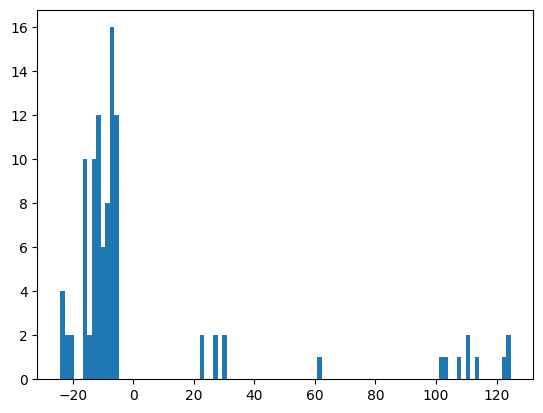

[ 124.7400,  22.8000, -16.3600,  30.0900, -16.0700, -15.4300,  -7.6600,  -7.3700,  -6.0000,  -5.4400, ]
[  22.8000, 122.9200, -12.0000,  27.1300, -12.3800, -12.0100,  -7.0300, -10.2800,  -5.8400,  -6.7600, ]
[ -16.3600, -12.0000,  61.7500, -14.3300, -13.2400, -10.8800, -23.4400, -21.4100, -20.5200, -24.1900, ]
[  30.0900,  27.1300, -14.3300, 124.7400, -16.0200, -16.5700,  -6.8700,  -6.9200,  -7.0200,  -8.4200, ]
[ -16.0700, -12.3800, -13.2400, -16.0200, 110.0400,  -5.4500,  -9.0100, -10.8300,  -7.0700, -12.6700, ]
[ -15.4300, -12.0100, -10.8800, -16.5700,  -5.4500, 113.3000,  -8.4300, -10.5400,  -5.9800, -13.2700, ]
[  -7.6600,  -7.0300, -23.4400,  -6.8700,  -9.0100,  -8.4300, 103.7100,  -8.9700,  -4.8500, -12.1100, ]
[  -7.3700, -10.2800, -21.4100,  -6.9200, -10.8300, -10.5400,  -8.9700, 107.2100, -11.9600, -13.2800, ]
[  -6.0000,  -5.8400, -20.5200,  -7.0200,  -7.0700,  -5.9800,  -4.8500, -11.9600, 110.0300, -10.3200, ]
[  -5.4400,  -6.7600, -24.1900,  -8.4200, -12.6700, -13.2700, -1

In [9]:
kernel, u = dictionary_inner_prod_sim(model, alphabet='z', bins=100)
print_neat_matrix(kernel)

In [ ]:
batch_size = 10
path="'/dlabdata1/masani/blocks/logs/training/runs/scan/suponly-[0.04, 0.9]-gpt2_gpt2-vqvae/2023-10-15_14-51-47/checkpoints/last.ckpt'"
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    config_sup_004 = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=scan", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}"
                                      ])

model_sup_004 , datamodule_sup_004 = run_inference(config_sup_004)

batch_size = 10
path="'/dlabdata1/masani/blocks/logs/training/runs/scan/curriculum-[0.04, 0.9]-gpt2_gpt2-vqvae/2023-10-17_14-13-22/checkpoints/last.ckpt'"
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    config_cur_004 = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=scan", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}"
                                      ])

model_cur_004, datamodule_cur_004 = run_inference(config_cur_004)
    

In [ ]:

annot = False
for alph in ['x', 'z']:
    if alph == 'x':
        bin = 100
        tokenizer=model.collator.tokenizer_x
    elif alph == 'z':
        bin = 20
        tokenizer=model.collator.tokenizer_z
    print(alph)
    for type in ['sup', 'cur']:
        print(type)
        if type == 'sup':
            model = model_sup_004
        elif type == 'cur':
            model = model_cur_004
        cosine_kernel, cosine_u = dictionary_cosine_sim(model, alphabet=alph, bins=bin)

        sorted_vocab = sorted(tokenizer.get_vocab().items(), key=lambda x: x[1])
        sorted_vocab = [x[0] for x in sorted_vocab]

        plt.figure()
        plt.title(alph+' '+type+' cosine similarity')
        sns.heatmap(cosine_kernel, cmap="coolwarm", annot=annot, xticklabels=sorted_vocab, yticklabels=sorted_vocab)
        plt.show()

        inner_prod_kernel, inner_prod_u = dictionary_inner_prod_sim(model, alphabet=alph, bins=bin)
        plt.figure()
        plt.title(alph+' '+type+' inner product similarity')
        sns.heatmap(inner_prod_kernel, cmap="coolwarm", annot=annot, xticklabels=sorted_vocab, yticklabels=sorted_vocab)
        plt.show()


# cos_sup_004, u_sup_004 = dictionary_cosine_sim(model_sup_004, bins=bin)
# cos_cur_004, u_cur_004 = dictionary_cosine_sim(model_cur_004, bins=bin)
# sns.heatmap(cos_sup_004, cmap="coolwarm", annot=True)
# plt.show()
# sns.heatmap(cos_cur_004, cmap="coolwarm", annot=True)
# plt.show()

### loading other datamodules and sampling outputs for the paper

In [ ]:
%cd ..
from src import utils
import hydra
from omegaconf import DictConfig
import numpy as np
import os
import torch
from src.utils.metrics import pad_label_label
# from src.utils import general_helpers
from typing import List
import seaborn as sns

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.loggers.logger import Logger

import src.utils.general as utils
# Load config
import hydra
import matplotlib.pyplot as plt

log = utils.get_pylogger(__name__)

configs_path = "../configs"
config_name = "inference_root.yaml"
work_dir='/dlabdata1/masani/blocks/'
batch_size = 32
path="'/dlabdata1/masani/blocks/logs/training/runs/scan/suponly-[0.99, 0.9]-gpt2_gpt2-vqvae/2023-11-17_15-54-41/checkpoints/last.ckpt'"

def load_datamodule(config: DictConfig):
    # assert config.output_dir is not None, "Path to the directory in which the predictions will be written must be given"
    # config.output_dir = general_helpers.get_absolute_path(config.output_dir)
    # log.info(f"Output directory: {config.output_dir}")

    # Set seed for random number generators in PyTorch, Numpy and Python (random)
    if config.get("seed"):
        pl.seed_everything(config.seed, workers=True)
    
    # print current working directory
    print(f"Current working directory: {os.getcwd()}")

    print(f"Instantiating data module <{config.datamodule._target_}>")
    datamodule: LightningDataModule = hydra.utils.instantiate(config.datamodule, _recursive_=False)

    return datamodule

def print_sample(datamodule, num_sample):
    ids = np.random.randint(0, len(datamodule.data_val), num_sample)
    for id in ids:
        print('id: ', id)
        print('x: ', datamodule.data_val[int(id)]['x'])
        print('z: ', datamodule.data_val[int(id)]['z'])
        print('_____________________________________________________________________________________')


In [ ]:
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    cnfig = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=cfq", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}",
                                      "work_dir='/dlabdata1/masani/blocks/'"
                                      ])
datamodule = load_datamodule(cnfig)
print_sample(datamodule, 5)

In [ ]:
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    cnfig = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=cogs", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}",
                                      "work_dir='/dlabdata1/masani/blocks/'"
                                      ])
datamodule = load_datamodule(cnfig)
print_sample(datamodule, 5)

In [ ]:
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    cnfig = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=pcfg_set", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}",
                                      "work_dir='/dlabdata1/masani/blocks/'"
                                      ])
datamodule = load_datamodule(cnfig)
print_sample(datamodule, 5)

In [ ]:
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    cnfig = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=sfst", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}"
                                      ])
datamodule = load_datamodule(cnfig)
print_sample(datamodule, 5)

In [ ]:
with hydra.initialize(config_path=configs_path, version_base="1.2"):
    cnfig = hydra.compose(config_name=config_name, 
                           overrides=["+experiment/inference=inference", 
                                      "datamodule=scan", "datamodule.dataset_parameters.supervision_ratio=[0.04,0.9]",
                                      "trainer.devices=[1]", 
                                      "training_type=suponly", 
                                      f"datamodule.dataset_parameters.batch_size={batch_size}", 
                                      "sequence_to_sequence_model_key=gpt2_gpt2", 
                                      "discretizer_key=vqvae",
                                      f"model.checkpoint_path={path}"
                                      ])
datamodule = load_datamodule(cnfig)
print_sample(datamodule, 5)